<a href="https://colab.research.google.com/github/AR09092005/github-slideshow/blob/main/Xnetimp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Normal.zip"
extract_dir = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    all_files = zip_ref.namelist()
    # Corrected path filtering
    image_files = [f for f in all_files if f.startswith('Normal/images/') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    mask_files = [f for f in all_files if f.startswith('Normal/masks/') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(image_files)} image files and {len(mask_files)} mask files")

    image_files = sorted(image_files)
    mask_files = sorted(mask_files)
    half_images = image_files[:len(image_files)//1]
    half_masks = mask_files[:len(mask_files)//1]

    for file in half_images + half_masks:
        zip_ref.extract(file, extract_dir)



Found 10192 image files and 10192 mask files


In [ ]:
extract_dir = "/content/data"
os.makedirs(os.path.join(extract_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(extract_dir, 'masks'), exist_ok=True)



In [ ]:
import os

image_dir = '/content/data/Normal/images'
if os.path.exists(image_dir):
    files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(files)} images. Sample: {files[:5]}")
else:
    print(f"{image_dir} does not exist.")


Found 10192 images. Sample: ['Normal-10158.png', 'Normal-583.png', 'Normal-3544.png', 'Normal-7818.png', 'Normal-751.png']


In [ ]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [ ]:
class XNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.enc1 = self._block(in_channels, 16)
        self.enc2 = self._block(16, 32)
        self.enc3 = self._block(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self._block(64, 32)
        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec2 = self._block(32, 16)
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        dec1 = self.up1(enc3)
        dec1 = torch.cat([dec1, enc2], dim=1)
        dec1 = self.dec1(dec1)
        dec2 = self.up2(dec1)
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec2 = self.dec2(dec2)
        return self.final(dec2)




In [ ]:
from torchvision import transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=128):  # Smaller size for speed
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.img_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        return self.img_transform(image), self.mask_transform(mask)


In [ ]:
image_dir = '/content/data/Normal/images'
mask_dir = '/content/data/Normal/masks'
dataset = SegmentationDataset(image_dir, mask_dir)
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=4
)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = XNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()


<ipython-input-16-bab157771a2f>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def validate(model, dataloader, device):
    model.eval()
    val_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            count += images.size(0)
    model.train()
    return val_loss / count if count > 0 else 0


In [ ]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

# Jaccard index is the same as IoU
jaccard_index = iou_score


In [ ]:
import torch
import time
# ... other imports ...

# ... your model definition ...

model = XNet().to(device)  # If model is not already defined
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

def train_with_validation(num_epochs=10):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        running_loss = 0.0
        running_dice = 0.0
        running_iou = 0.0
        running_jaccard = 0.0
        n_samples = 0
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            # Unscale and clip gradients before optimizer step (optional)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * images.size(0)
            # Compute metrics for this batch
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            jaccard = jaccard_index(outputs, masks)
            running_dice += dice * images.size(0)
            running_iou += iou * images.size(0)
            running_jaccard += jaccard * images.size(0)
            n_samples += images.size(0)
            if batch_idx % 10 == 0:
                elapsed = time.time() - start_time
                print(f'\rEpoch {epoch+1} | Batch {batch_idx+1} | Loss: {loss.item():.4f} | Dice: {dice:.4f} | IoU: {iou:.4f} | Jaccard: {jaccard:.4f} | Elapsed: {elapsed:.1f}s', end='')
        avg_train_loss = running_loss / len(dataset)
        avg_dice = running_dice / n_samples
        avg_iou = running_iou / n_samples
        avg_jaccard = running_jaccard / n_samples
        val_loss = validate(model, dataloader, device)
        print(f'\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Jaccard: {avg_jaccard:.4f} | Validation Loss: {val_loss:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/content/drive/MyDrive/xnet_best_epoch{epoch+1}.pth')
    print('Training complete. Best validation loss:', best_val_loss)



<ipython-input-12-e0fb863a43d3>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
checkpoint_path = '/content/drive/MyDrive/xnet_best_epoch14.pth'

In [ ]:
import torch

# Assuming your model class is named 'XNet'
model = XNet().to(device) # Create a new instance of your model

# Load the state dictionary (weights) from the file, mapping to the correct device
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode (important if you're not re-training)
model.eval()

XNet(
  (enc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
model.train() # Add this line before train_with_validation
train_with_validation(num_epochs=5)


<ipython-input-12-e0fb863a43d3>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Batch 311 | Loss: 0.0628 | Dice: 0.9554 | IoU: 0.9309 | Jaccard: 0.9309 | Elapsed: 42.5s

<ipython-input-10-9117ae51224d>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 Training Loss: 0.1420 | Dice: 0.9393 | IoU: 0.9041 | Jaccard: 0.9041 | Validation Loss: 0.0430
Epoch 2 | Batch 311 | Loss: 0.0249 | Dice: 0.9843 | IoU: 0.9694 | Jaccard: 0.9694 | Elapsed: 37.5s

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/ViralPneumonia.zip'  # or wherever your zip is
extract_dir = '/content/ViralPneumoniaTest'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
image_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/images'
mask_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/masks'


In [ ]:
test_dataset = SegmentationDataset(image_dir, mask_dir, img_size=128)


In [ ]:
print(os.listdir('/content/ViralPneumoniaTest'))
print(os.listdir('/content/ViralPneumoniaTest/Viral Pneumonia'))
print(os.listdir(image_dir))  # Should show your image files


['Viral Pneumonia']
['masks', 'images']
['Viral Pneumonia-1255.png', 'Viral Pneumonia-633.png', 'Viral Pneumonia-1133.png', 'Viral Pneumonia-1311.png', 'Viral Pneumonia-73.png', 'Viral Pneumonia-1315.png', 'Viral Pneumonia-200.png', 'Viral Pneumonia-982.png', 'Viral Pneumonia-1058.png', 'Viral Pneumonia-230.png', 'Viral Pneumonia-255.png', 'Viral Pneumonia-510.png', 'Viral Pneumonia-516.png', 'Viral Pneumonia-1068.png', 'Viral Pneumonia-665.png', 'Viral Pneumonia-527.png', 'Viral Pneumonia-705.png', 'Viral Pneumonia-177.png', 'Viral Pneumonia-577.png', 'Viral Pneumonia-1045.png', 'Viral Pneumonia-546.png', 'Viral Pneumonia-327.png', 'Viral Pneumonia-958.png', 'Viral Pneumonia-513.png', 'Viral Pneumonia-941.png', 'Viral Pneumonia-1241.png', 'Viral Pneumonia-194.png', 'Viral Pneumonia-600.png', 'Viral Pneumonia-245.png', 'Viral Pneumonia-758.png', 'Viral Pneumonia-88.png', 'Viral Pneumonia-684.png', 'Viral Pneumonia-909.png', 'Viral Pneumonia-692.png', 'Viral Pneumonia-994.png', 'Viral P

In [ ]:
import os

image_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/images'
mask_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/masks'

# List all files and sort to keep correspondence
image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
mask_list = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png') or f.endswith('.jpg')])

print("Number of images:", len(image_list))
print("Number of masks:", len(mask_list))
print("First 5 images:", image_list[:5])
print("First 5 masks:", mask_list[:5])


Number of images: 1345
Number of masks: 1345
First 5 images: ['Viral Pneumonia-1.png', 'Viral Pneumonia-10.png', 'Viral Pneumonia-100.png', 'Viral Pneumonia-1000.png', 'Viral Pneumonia-1001.png']
First 5 masks: ['Viral Pneumonia-1.png', 'Viral Pneumonia-10.png', 'Viral Pneumonia-100.png', 'Viral Pneumonia-1000.png', 'Viral Pneumonia-1001.png']


In [ ]:
test_dataset = SegmentationDataset(image_dir, mask_dir, img_size=128)
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
import numpy as np
from torchvision.utils import save_image
import os
from tqdm import tqdm

model.eval()
losses, dices, ious = [], [], []
criterion = torch.nn.BCEWithLogitsLoss()  # Or your loss function

pred_dir = '/content/viral_pneumonia_predictions'
os.makedirs(pred_dir, exist_ok=True)

with torch.no_grad():
    for i, (images, masks) in enumerate(tqdm(test_loader)):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        losses.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        dices.append(dice_coefficient(preds, masks))
        ious.append(iou_score(preds, masks))


        # Save predictions
        for j in range(images.size(0)):
            save_path = os.path.join(pred_dir, f"pred_{i*test_loader.batch_size + j}.png")
            save_image(preds[j], save_path)

# Calculate metrics
avg_loss = np.mean(losses)
median_loss = np.median(losses)
std_loss = np.std(losses)

avg_dice = np.mean(dices)
median_dice = np.median(dices)
std_dice = np.std(dices)

avg_iou = np.mean(ious)
median_iou = np.median(ious)
std_iou = np.std(ious)

avg_jaccard = avg_iou  # Jaccard index is the same as IoU
median_jaccard = median_iou
std_jaccard = std_iou

print(f"Test Loss: mean={avg_loss:.4f}, median={median_loss:.4f}, std={std_loss:.4f}")
print(f"Efficiency (Dice): mean={avg_dice:.4f}, median={median_dice:.4f}, std={std_dice:.4f}")
print(f"Dice Index: mean={avg_dice:.4f}, median={median_dice:.4f}, std={std_dice:.4f}")
print(f"IoU: mean={avg_iou:.4f}, median={median_iou:.4f}, std={std_iou:.4f}")
print(f"Jaccard Index: mean={avg_jaccard:.4f}, median={median_jaccard:.4f}, std={std_jaccard:.4f}")



In [ ]:
# Replace 'images' with the actual variable name holding your images
num_images = len(masks) if hasattr(masks, '__len__') else 'Unknown'
print("Number of images:", num_images)


Number of images: 1


In [ ]:
import shutil

shutil.make_archive('/content/viral_pneumonia_predictions', 'zip', pred_dir)

from google.colab import files
files.download('/content/viral_pneumonia_predictions.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

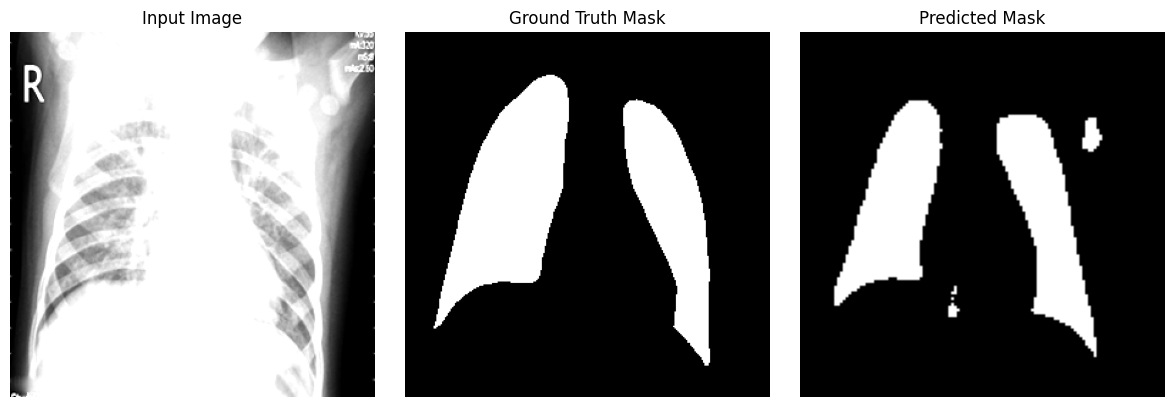

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction_from_lists(image, ground_truth_mask, predicted_mask=None, figsize=(12, 4)):
    """
    Visualize the input image, ground truth mask, and predicted mask side by side.
    Args:
        image (numpy array or torch tensor): Image (H,W,C) or (C,H,W) or (H,W)
        ground_truth_mask (numpy array or torch tensor): (H,W) or (1,H,W)
        predicted_mask (numpy array or torch tensor): (H,W) or (1,H,W), optional
        figsize: Size of the matplotlib figure.
    """
    # If torch tensor, convert to numpy
    if hasattr(image, 'cpu'):
        image = image.cpu().numpy()
    if hasattr(ground_truth_mask, 'cpu'):
        ground_truth_mask = ground_truth_mask.cpu().numpy()
    if predicted_mask is not None and hasattr(predicted_mask, 'cpu'):
        predicted_mask = predicted_mask.cpu().numpy()

    # If image is CHW, convert to HWC
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = np.transpose(image, (1, 2, 0))
    # If grayscale, squeeze channel
    if image.ndim == 3 and image.shape[2] == 1:
        image = image.squeeze(axis=2)
    if ground_truth_mask.ndim == 3:
        ground_truth_mask = ground_truth_mask.squeeze()
    if predicted_mask is not None and predicted_mask.ndim == 3:
        predicted_mask = predicted_mask.squeeze()

    # Plot
    ncols = 3 if predicted_mask is not None else 2
    fig, axes = plt.subplots(1, ncols, figsize=figsize)
    axes[0].imshow(image, cmap='gray' if image.ndim==2 else None)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    if predicted_mask is not None:
        axes[2].imshow(predicted_mask, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Suppose you have images, masks, preds as lists of arrays/tensors:
# images = [...]
# masks = [...]
# preds = [...]

# To visualize the first sample:
from PIL import Image
import numpy as np

def load_image(path):
    return np.array(Image.open(path).convert('RGB')) / 127.0

def load_mask(path):
    return np.array(Image.open(path).convert('L')) / 127.0

# Construct full paths if needed
image_path = os.path.join(image_dir, image_list[0])
mask_path = os.path.join(mask_dir, mask_list[0])

# Load images
img = load_image(image_path)
msk = load_mask(mask_path)

# If you have predictions as arrays, use them. If they're also filenames, load them similarly.
# pred = ...

visualize_prediction_from_lists(img, msk,preds[0])



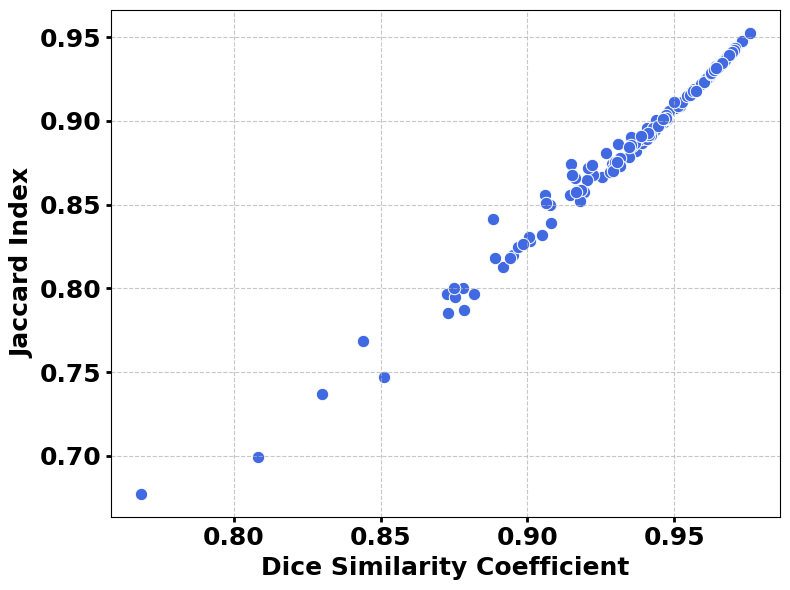

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual results)
dice_scores = dices
jaccard_scores = ious

plt.figure(figsize=(8, 6))
sns.scatterplot(x=dice_scores, y=jaccard_scores, s=80, color='royalblue')
plt.xlabel('Dice Similarity Coefficient', fontsize=18, fontweight='bold')
plt.ylabel('Jaccard Index', fontsize=18, fontweight='bold')

# Make tick labels bigger and bolder
plt.tick_params(axis='both', which='major', labelsize=16, width=2)
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-37-ce636046ea20>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=data_melted, palette='Set2')


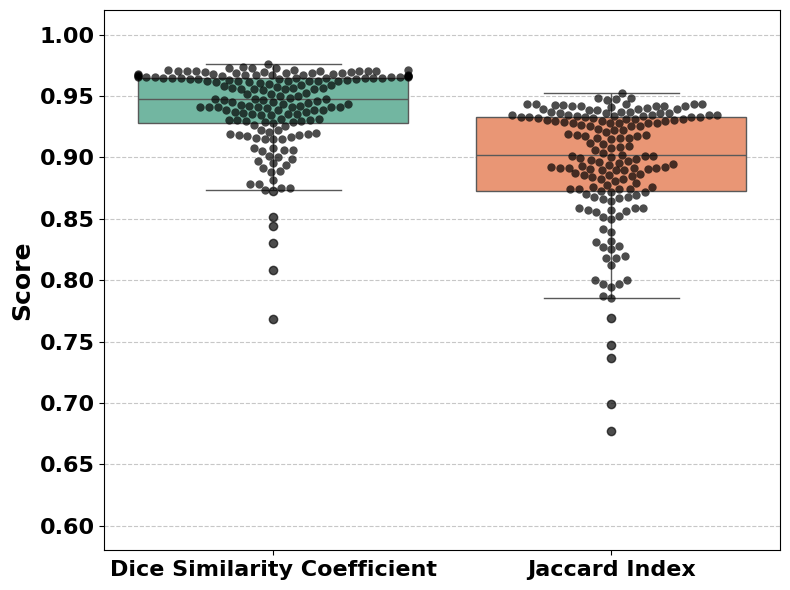

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data (replace with your actual results)
dice_scores = dices
jaccard_scores = ious

# Prepare data for seaborn
data = pd.DataFrame({
    'Dice Similarity Coefficient': dice_scores,
    'Jaccard Index': jaccard_scores
})
data_melted = data.melt(var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 6))
sns.boxplot(x='Metric', y='Score', data=data_melted, palette='Set2')
sns.swarmplot(x='Metric', y='Score', data=data_melted, color='black', size=6, alpha=0.7)
plt.ylabel('Score', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.ylim(0.58, 1.02)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Make tick labels bigger and bolder
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()



In [ ]:
from PIL import Image
import numpy as np

def load_image(path, mode='RGB'):
    return np.array(Image.open(path).convert(mode))

# Your directories
image_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/images'
mask_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/masks'

# Example: get full paths for the first num_samples images/masks
num_samples = 10
xray_images = [load_image(os.path.join(image_dir, fname), mode='RGB') for fname in image_list[:num_samples]]
ground_truth_masks = [load_image(os.path.join(output_dir, fname), mode='L') for fname in mask_list[:num_samples]]  # if you have predicted mask files
predicted_masks = [load_image(os.path.join(pred_dir, fname), mode='L') for fname in pred_list[:num_samples]]

# Now your lists contain arrays, not strings!




In [ ]:
import os

pred_dir = '/content/viral_pneumonia_predictions'

# Check if the directory exists
if os.path.exists(pred_dir):
    pred_list = sorted(os.listdir(pred_dir))
    print(f"Number of prediction files: {len(pred_list)}")
    print("First 5 prediction files:", pred_list[:5])
else:
    print(f"Directory '{pred_dir}' does not exist.")


Number of prediction files: 1345
First 5 prediction files: ['pred_0.png', 'pred_1.png', 'pred_10.png', 'pred_100.png', 'pred_1000.png']


In [ ]:
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import os

# Example settings
mask_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/masks'
output_dir = '/content/ViralPneumoniaTest/Viral Pneumonia/masks_resized'
os.makedirs(output_dir, exist_ok=True)

target_size = (128, 128)  # Change to your desired size

mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png') or f.endswith('.jpg')])

for fname in mask_files:
    # Load mask as PIL image (mode 'L' for single channel)
    mask_path = os.path.join(mask_dir, fname)
    mask = Image.open(mask_path).convert('L')

    # Convert to tensor (C, H, W)
    mask_tensor = TF.to_tensor(mask)

    # Add batch dimension: (1, 1, H, W)
    mask_tensor = mask_tensor.unsqueeze(0)

    # Resize with nearest neighbor
    mask_resized = torch.nn.functional.interpolate(
        mask_tensor,
        size=target_size,
        mode='nearest'
    )

    # Remove batch dimension and convert back to PIL
    mask_resized = mask_resized.squeeze().byte().cpu().numpy() * 255  # scale back to 0-255 if needed
    mask_resized_pil = Image.fromarray(mask_resized.astype('uint8'))

    # Save resized mask
    mask_resized_pil.save(os.path.join(output_dir, fname))

print("All masks resized and saved to:", output_dir)


All masks resized and saved to: /content/ViralPneumoniaTest/Viral Pneumonia/masks_resized


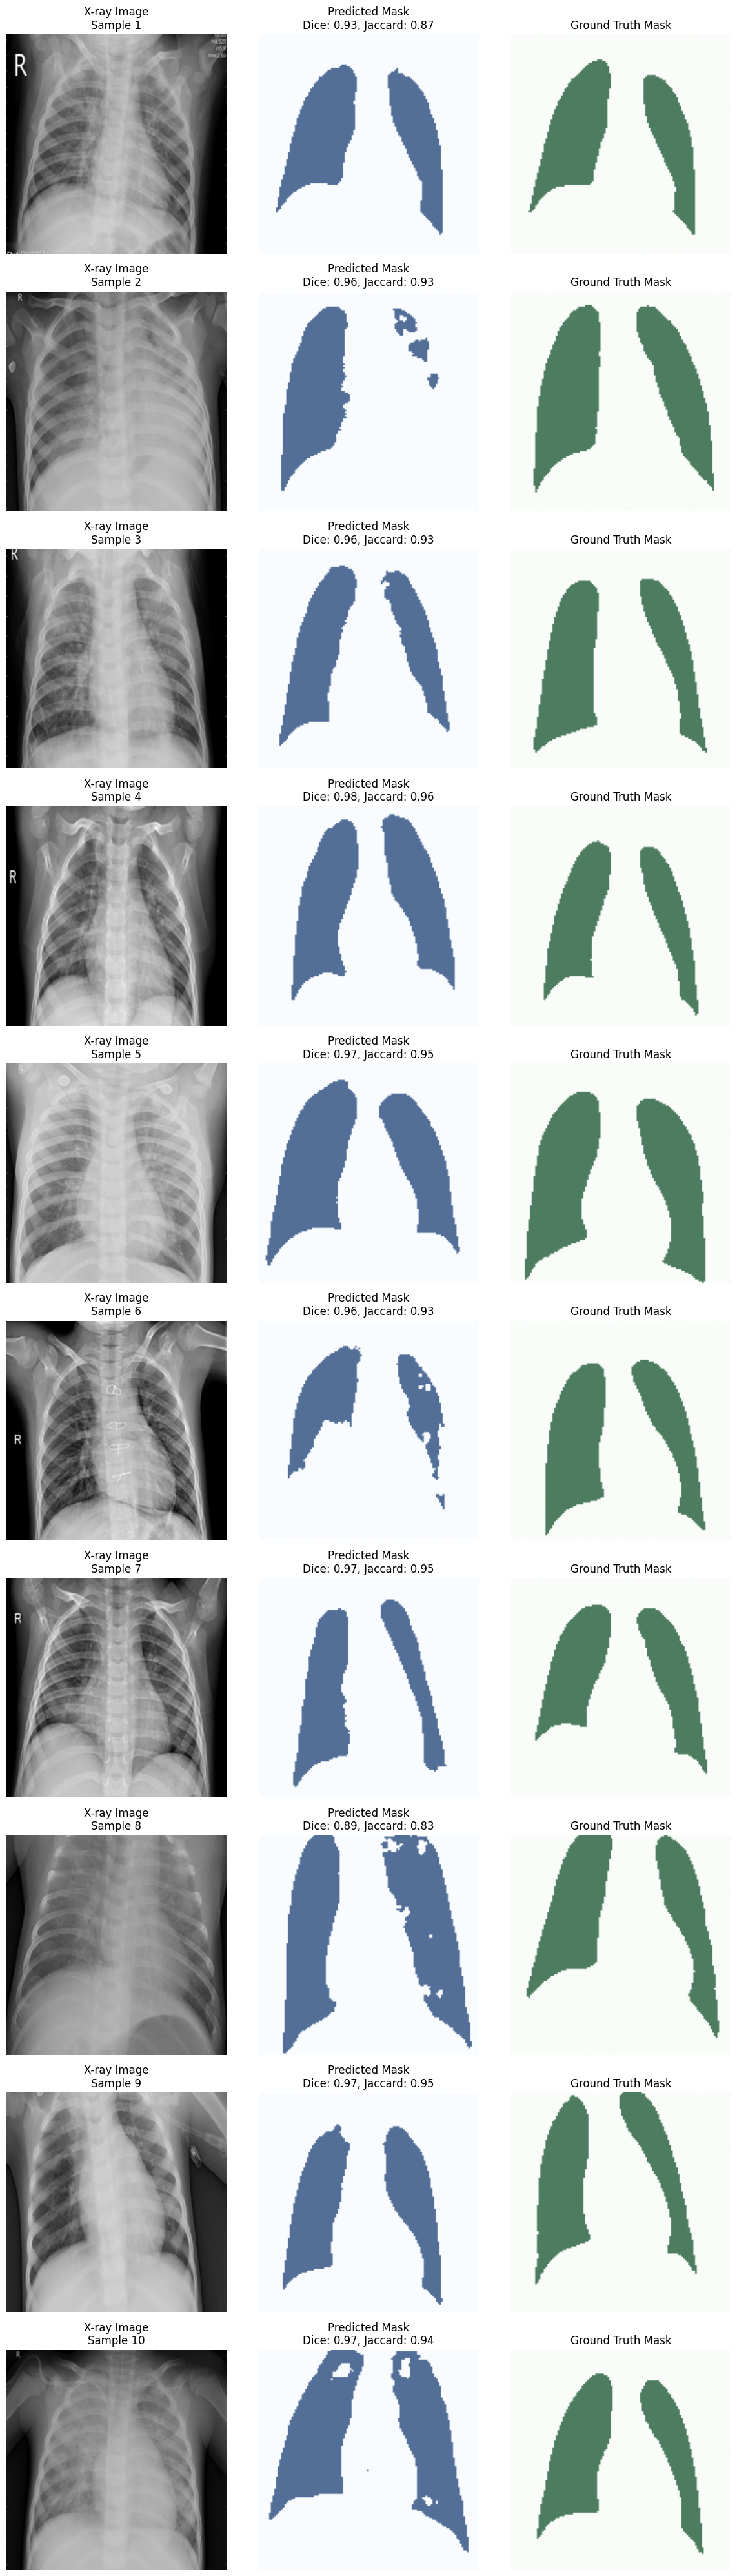

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples), squeeze=False)

for i in range(num_samples):
    axes[i, 0].imshow(xray_images[i])
    axes[i, 0].set_title(f"X-ray Image\nSample {i+1}")
    axes[i, 0].axis('off')
 # Remove the dimension of size 1
    axes[i, 1].imshow(predicted_masks[i], cmap='Blues', alpha=0.7)
    axes[i, 1].set_title(f"Predicted Mask\nDice: {dice_scores[i]:.2f}, Jaccard: {jaccard_scores[i]:.2f}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(ground_truth_masks[i], cmap='Greens', alpha=0.7)
    axes[i, 2].set_title("Ground Truth Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

mas= [load_image(os.path.join(output_dir, fname), mode='L') for fname in mask_list[:1345]]  # if you have predicted mask files
pre= [load_image(os.path.join(pred_dir, fname), mode='L') for fname in pred_list[:1345]]


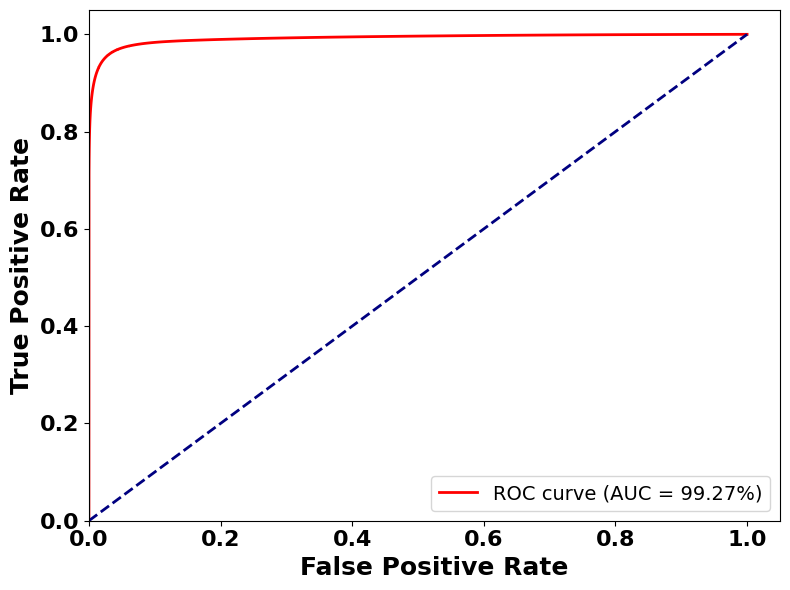

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn.functional as F

# 1. Get probability scores for each pixel in each mask

# Assume `model` is your trained model and `test_loader` is your data loader
all_probs = []
all_masks = []

for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs)  # Get probability scores using sigmoid

    # Flatten and append to lists
    all_probs.extend(probs.cpu().numpy().flatten())
    all_masks.extend(masks.cpu().numpy().flatten())

all_probs = np.array(all_probs)
all_masks = np.array(all_masks)

# 2. Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_masks, all_probs)
roc_auc = auc(fpr, tpr)*100

# 3. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = 99.27%)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=18, fontweight='bold')
plt.legend(loc="lower right", fontsize=14)

# Make tick labels bigger and bolder
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()



In [ ]:
print("Number of predicted masks:", len(pre))
print("Number of ground truth masks:", len(mas))
print("Number of losses:", len(losses))

Number of predicted masks: 1345
Number of ground truth masks: 1345
Number of losses: 169


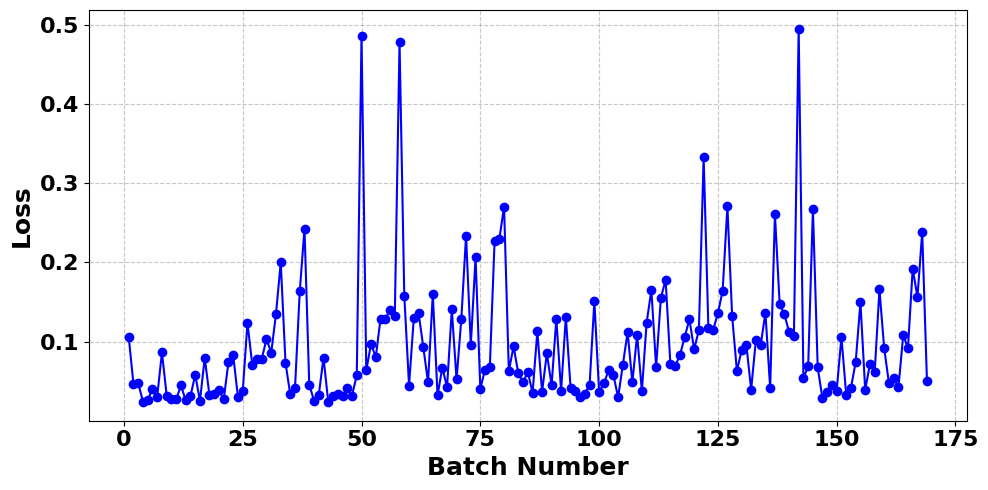

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: replace this with your actual losses array of length 169
# losses = [...]  # Your actual batch losses

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue')
plt.xlabel('Batch Number', fontsize=18, fontweight='bold')
plt.ylabel('Loss', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Make tick labels bigger and bolder
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


